In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from tqdm import tqdm
import annoy
import random
import numpy as np
import pandas as pd
import seaborn as sns
import time
from collections import defaultdict
from sklearn.manifold import spectral_embedding, MDS
from scipy.spatial.distance import squareform, pdist, cdist
from sklearn.decomposition import PCA

import numpy as np
from numba import njit, jit
from numba import types
from numba.typed import Dict
from scipy.cluster.hierarchy import linkage
from matplotlib.colors import BASE_COLORS
from helpers import mds, write_embedding_to_text_file, write_embedding_to_two_text_files, is_numeric
from sklearn.neighbors import NearestNeighbors
from sequence import *
from linkage_based_embeddings import *

def plot_reduced_embeddings(entity_ids, reduced_embeddings):    
    entity_id_to_color = {unique_entity_id: np.random.random(3) for unique_entity_id in set(entity_ids)}
    plt.scatter(
        x=reduced_embeddings[:,0],
        y=reduced_embeddings[:,1],
        c=[entity_id_to_color[i] for i in entity_ids]
    )
    mins = np.min(reduced_embeddings, axis=0)
    maxs = np.max(reduced_embeddings, axis=0)
    plt.xlim((mins[0] - abs(mins[0]*0.5), maxs[0] + abs(maxs[0]*0.5)))
    plt.ylim((mins[1] - abs(mins[1]*0.5), maxs[1] + abs(maxs[1]*0.5)))


unable to import 'smart_open.gcs', disabling that module


In [2]:
# DNA Simulation Dataset
def generate_condensed_raw_distance_matrix(num_mutations, num_modifications, num_starts, sequence_length):
    base_sequence_list = []
    base = np.random.choice(["A", "C", "G", "T"], sequence_length)
    for i in tqdm(range(num_starts)):
        modified_sequence = [s for s in base]
        for i in range(num_modifications):
            modified_sequence = mutate_sequence(modified_sequence)
        base_sequence_list.append(np.array(modified_sequence)[None,...])
    base_sequences = np.vstack(base_sequence_list)

    entity_ids = []
    raw_embeddings = []
    for i, b in tqdm(enumerate(base_sequences)):
        entity_ids += [i for j in range(num_mutations)]
        raw_embeddings += generate_mutation_chain(base_sequence=b, num_mutations=num_mutations)

    metric = sequence_distance
    return entity_ids, pdist(raw_embeddings, metric=metric)

num_modifications = 100
sequence_length = 1000


In [3]:
all_results = []
for drop_first in [False]:
    for n_components in [2, 5]:
        for num_starts in [100, 200]:
            for num_mutations in [10, 20]: 
                start = time.time()
                entity_ids, condensed_raw_distance_matrix = generate_condensed_raw_distance_matrix(
                    num_mutations=num_mutations,
                    num_modifications=num_modifications,
                    num_starts=num_starts,
                    sequence_length=sequence_length)

                results = {}
                results["entity_ids"] = entity_ids
                results["n_components"] = n_components
                results["num_starts"] = num_starts
                results["num_mutations"] = num_mutations

                results["maximal_linkage_mds_embeddings"] = maximal_linkage_mds_from_condensed(
                    condensed_raw_distance_matrix, n_components=n_components)
                results["maximal_linkage_mds_from_condensed"] = evaluate_embeddings(
                    embedding_sequence=results["maximal_linkage_mds_embeddings"], num_mutations=num_mutations)

                results["single_linkage_mds_embeddings"] = single_linkage_mds_from_condensed(
                    condensed_raw_distance_matrix, n_components=n_components)
                results["single_linkage_mds_from_condensed"] = evaluate_embeddings(
                    embedding_sequence=results["single_linkage_mds_embeddings"], num_mutations=num_mutations)

                print("============")
                for k, v in results.items():
                    if "embeddings" not in k and "entity_ids" not in k:
                        print(k, v)
                all_results.append(results)
                print(time.time() - start)


100%|██████████| 50/50 [00:00<00:00, 144.93it/s]
50it [00:00, 968.73it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
 30%|███       | 15/50 [00:00<00:00, 147.34it/s]

n_components 2
num_starts 50
num_mutations 10
maximal_linkage_mds_from_condensed 0.86
single_linkage_mds_from_condensed 0.96
21.525787115097046


100%|██████████| 50/50 [00:00<00:00, 149.72it/s]
50it [00:00, 583.54it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
  9%|▉         | 9/100 [00:00<00:01, 82.37it/s]

n_components 2
num_starts 50
num_mutations 20
maximal_linkage_mds_from_condensed 0.56
single_linkage_mds_from_condensed 0.98
69.34171104431152


100%|██████████| 100/100 [00:00<00:00, 101.48it/s]
100it [00:00, 694.40it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
 15%|█▌        | 15/100 [00:00<00:00, 147.18it/s]

n_components 2
num_starts 100
num_mutations 10
maximal_linkage_mds_from_condensed 0.13
single_linkage_mds_from_condensed 0.73
85.87117314338684


100%|██████████| 100/100 [00:00<00:00, 145.88it/s]
100it [00:00, 593.64it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
  8%|▊         | 15/200 [00:00<00:01, 149.16it/s]

n_components 2
num_starts 100
num_mutations 20
maximal_linkage_mds_from_condensed 0.01
single_linkage_mds_from_condensed 0.68
243.5480740070343


100%|██████████| 200/200 [00:01<00:00, 154.59it/s]
200it [00:00, 1071.60it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
  9%|▉         | 18/200 [00:00<00:01, 176.39it/s]

n_components 2
num_starts 200
num_mutations 10
maximal_linkage_mds_from_condensed 0.01
single_linkage_mds_from_condensed 0.275
204.92307996749878


100%|██████████| 200/200 [00:01<00:00, 177.87it/s]
200it [00:00, 668.18it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
 42%|████▏     | 21/50 [00:00<00:00, 203.49it/s]

n_components 2
num_starts 200
num_mutations 20
maximal_linkage_mds_from_condensed 0.0
single_linkage_mds_from_condensed 0.205
857.7032041549683


100%|██████████| 50/50 [00:00<00:00, 212.10it/s]
50it [00:00, 1572.37it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
 30%|███       | 15/50 [00:00<00:00, 147.17it/s]

n_components 5
num_starts 50
num_mutations 10
maximal_linkage_mds_from_condensed 1.0
single_linkage_mds_from_condensed 1.0
17.533931970596313


100%|██████████| 50/50 [00:00<00:00, 148.19it/s]
50it [00:00, 618.09it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
 17%|█▋        | 17/100 [00:00<00:00, 162.50it/s]

n_components 5
num_starts 50
num_mutations 20
maximal_linkage_mds_from_condensed 1.0
single_linkage_mds_from_condensed 1.0
59.09070181846619


100%|██████████| 100/100 [00:00<00:00, 170.41it/s]
100it [00:00, 1232.56it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
 16%|█▌        | 16/100 [00:00<00:00, 159.28it/s]

n_components 5
num_starts 100
num_mutations 10
maximal_linkage_mds_from_condensed 0.76
single_linkage_mds_from_condensed 0.93
53.78043723106384


100%|██████████| 100/100 [00:00<00:00, 163.90it/s]
100it [00:00, 682.92it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
  8%|▊         | 16/200 [00:00<00:01, 157.30it/s]

n_components 5
num_starts 100
num_mutations 20
maximal_linkage_mds_from_condensed 0.13
single_linkage_mds_from_condensed 0.93
209.13406586647034


100%|██████████| 200/200 [00:01<00:00, 158.22it/s]
200it [00:00, 1071.96it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
  9%|▉         | 18/200 [00:00<00:01, 172.99it/s]

n_components 5
num_starts 200
num_mutations 10
maximal_linkage_mds_from_condensed 0.075
single_linkage_mds_from_condensed 0.44
210.95595788955688


100%|██████████| 200/200 [00:01<00:00, 174.48it/s]
200it [00:00, 665.12it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
 40%|████      | 20/50 [00:00<00:00, 197.29it/s]

n_components 5
num_starts 200
num_mutations 20
maximal_linkage_mds_from_condensed 0.025
single_linkage_mds_from_condensed 0.15
864.2780051231384


100%|██████████| 50/50 [00:00<00:00, 195.78it/s]
50it [00:00, 1540.55it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
 22%|██▏       | 11/50 [00:00<00:00, 102.14it/s]

n_components 10
num_starts 50
num_mutations 10
maximal_linkage_mds_from_condensed 1.0
single_linkage_mds_from_condensed 1.0
21.092117071151733


100%|██████████| 50/50 [00:00<00:00, 122.86it/s]
50it [00:00, 586.81it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
 13%|█▎        | 13/100 [00:00<00:00, 129.83it/s]

n_components 10
num_starts 50
num_mutations 20
maximal_linkage_mds_from_condensed 1.0
single_linkage_mds_from_condensed 1.0
72.45135021209717


100%|██████████| 100/100 [00:00<00:00, 143.70it/s]
100it [00:00, 1049.15it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
 16%|█▌        | 16/100 [00:00<00:00, 156.71it/s]

n_components 10
num_starts 100
num_mutations 10
maximal_linkage_mds_from_condensed 0.99
single_linkage_mds_from_condensed 1.0
67.53340911865234


100%|██████████| 100/100 [00:00<00:00, 154.38it/s]
100it [00:00, 651.58it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
  8%|▊         | 17/200 [00:00<00:01, 164.45it/s]

n_components 10
num_starts 100
num_mutations 20
maximal_linkage_mds_from_condensed 0.71
single_linkage_mds_from_condensed 1.0
216.97978281974792


100%|██████████| 200/200 [00:01<00:00, 173.58it/s]
200it [00:00, 1273.07it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
  8%|▊         | 16/200 [00:00<00:01, 157.55it/s]

n_components 10
num_starts 200
num_mutations 10
maximal_linkage_mds_from_condensed 0.235
single_linkage_mds_from_condensed 0.62
213.79994297027588


100%|██████████| 200/200 [00:01<00:00, 158.86it/s]
200it [00:00, 602.25it/s]
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


n_components 10
num_starts 200
num_mutations 20
maximal_linkage_mds_from_condensed 0.035
single_linkage_mds_from_condensed 0.325
839.5016269683838


Text(0, 0.5, 'Y Component of 2-Dimensional Embedding')

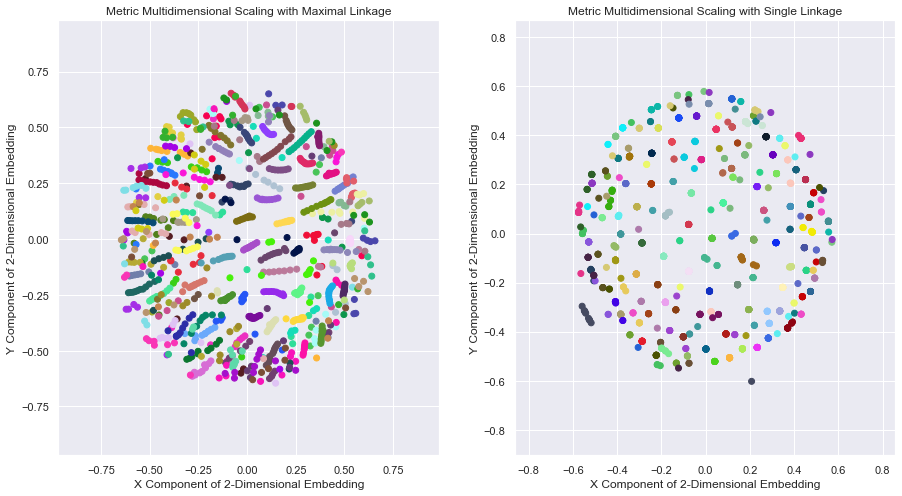

In [4]:
result = all_results[2]

plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
plt.title("Metric Multidimensional Scaling with Maximal Linkage")
plot_reduced_embeddings(result["entity_ids"], result['maximal_linkage_mds_embeddings'])
plt.xlabel("X Component of 2-Dimensional Embedding")
plt.ylabel("Y Component of 2-Dimensional Embedding")


plt.subplot(1,2,2)
plt.title("Metric Multidimensional Scaling with Single Linkage")
plot_reduced_embeddings(result["entity_ids"], result['single_linkage_mds_embeddings'])
plt.xlabel("X Component of 2-Dimensional Embedding")
plt.ylabel("Y Component of 2-Dimensional Embedding")

